# COVID-19
--- 
### Country similarities

The aim of this notebook is to find similarities between country spread growth. The analysis is using the data provided by the Kaggle spread prediction competiton and some additional source for providing the country details. 

In [2]:
import os
import time
import statistics

import numpy as np 
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm
from matplotlib    import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
# %matplotlib inline
sns.set()
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_log_error
from pandas_profiling import ProfileReport
import warnings 
warnings.filterwarnings('ignore')

Load the training data from kaggle data.

In [3]:
trainData = pd.read_csv('../assets/train.csv', parse_dates=['Date'])

In [4]:
def preprocess_train(df):

    # fill the state field with name of the country (if it is null)
    renameState     = df['Province_State'].fillna(0).values
    renameCountries = df['Country_Region'].values
    renameState[renameState == 0] = renameCountries[renameState == 0]
    df['Province_State'] = renameState

    return df

In [5]:
trainData = preprocess_train(trainData)

In [6]:
trainData.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,Afghanistan,Afghanistan,2020-01-22,0.0,0.0
1,2,Afghanistan,Afghanistan,2020-01-23,0.0,0.0
2,3,Afghanistan,Afghanistan,2020-01-24,0.0,0.0
3,4,Afghanistan,Afghanistan,2020-01-25,0.0,0.0
4,5,Afghanistan,Afghanistan,2020-01-26,0.0,0.0


Because the purpose of this notebook is note to explore the data, just an overview using pandas profiling is provided.

In [7]:
profile = ProfileReport(trainData, title='Growth report', html={'style':{'full_width':True}}, progress_bar=False)
profile.to_widgets()

## 1. Curve matching country similarity

This section will analyze the simmilarities of countries by simply comparing their growth considering multiple errors just from the point of view of deseas spread evolution. 

The comparison will be dealt by making comparison and **alignment point**. The alignment point is a threshod from when we can consider that the pandamy has start spreading in a specific/particular country.

### 1.1 Errors 

#### 1.1.1 Percentual error

Return the mean percentual error relative to the corresponding value.

Example:
    - source: [1, 2, 3]
    - target: [2, 3, 4]
    - error: 
        - 1/2 = 50%
        - 2/3 = 66%
        - 3/4 = 75%
    - mean error = mean(error)

In [8]:
def l1_error_norm(source, candidate):
    error = (abs(source - candidate))
    
    # can not divide by 0, add for numerical stability
    source[source == 0] = 1e-30
    
    # compute the percentage
    error = error/source
    error = error.mean()
    
    return error

##### 1.1.2 L1 norm 

For every Xn, compute the corresponding error as ```|Ysource - Ytarge|```.
Return the mean value of the error

In [9]:
def l1_error(source, candidate):
    error = abs(source - candidate)
    error = error.mean()
    
    return error

##### 1.1.3 L2 norm

For every Xn, compute the corresponding error as ```|Ysource - Ytarge|^2```.
Return the mean value of the error

In [10]:
def l2_error(source, candidate):
    error  = (abs(source - candidate))

    error = error * error
    error  = error.mean()
    
    return error

#### 1.1.4 Root Mean Squared Log Error

I have included this loss because it was the evaluation metri

In [11]:
def rmsle_error(source, candidate):
    candidate += 1e-30
    error  = np.log10((source+1)/(candidate+1))
    error  = error * error
    error  = error.mean()
    error  = np.sqrt(error) 
    
    return error

### 1.2 Comparing data 

In order to find similarities between countries we compare the source country data with the target country in a sliding window manner. In the case that the target data has not enough samples, it's safe to asume that the countries are not alike and that it can be ignored. 

The functin will return the minimum error and the index from where that(the 2 sequence from source and target countries) is.

In [12]:
 def compare_sequence(source, candidate, errorFunc):

        minError  = np.inf
        minIdx    = -1

        # only check the countries that can influence
        if len(candidate) > len(source):
            noWindows  = len(candidate) - len(source)
            windowSize = len(source)

            # sliding window over candidate country
            for i in range(0, noWindows):

                # compute loss
                error = errorFunc(source, candidate[i:i+windowSize])

                # save the min error
                if error <= minError:
                    minError = error
                    minIdx = i

            return minError, minIdx

        return None, None

### 1.3 Get nearest neighbours

In [13]:
 def get_nearest_sequence(df, state, alignThreshConf = 50, alignThreshDead = 10, errorFunc = l1_error):
    resDf = pd.DataFrame(columns=['Province_State', 'deathError', 'confirmedError', 'deathIdx', 'confirmedIdx'])
    confDf = df[df['ConfirmedCases'] > alignThreshConf]
    deadDf = df[df['Fatalities'] > alignThreshDead]
    
    # get source region data
    regionDfConf = confDf[confDf['Province_State'] == state].sort_values(by='Date', ascending=True)
    regionDfDead = deadDf[deadDf['Province_State'] == state].sort_values(by='Date', ascending=True)
    
    regionConf = regionDfConf['ConfirmedCases'].values
    regionDead = regionDfDead['Fatalities'].values
    
    # check all possible candidates
    for neighbour in df['Province_State'].unique():

        # skip comparing with the same country
        if neighbour == state:
            continue

        # get country candidate
        confNeighDf = confDf[confDf['Province_State'] == neighbour].sort_values(by='Date', ascending = True)
        deadNeighDf = deadDf[deadDf['Province_State'] == neighbour].sort_values(by='Date',  ascending = True)

        neighConf = confNeighDf['ConfirmedCases'].values
        neighDead = deadNeighDf['Fatalities'].values

        # get error for confirmed and neighbour
        confErr, confIdx = compare_sequence(regionConf, neighConf, errorFunc)
        deadErr, deadIdx = compare_sequence(regionDead, neighDead, errorFunc)
        
        # the candidate will be ignored if it does not have enough data
        if confErr is None or deadErr is None:
            continue

        # append result
        res = {'Province_State':neighbour, 'deathError':deadErr, 'confirmedError':confErr,
                   'deathIdx':deadIdx, 'confirmedIdx':confIdx}

        resDf = resDf.append(res, ignore_index=True)

    return resDf

### 1.4 Visualizing results

As an example we consider as alignment point **50 confirmed cases**. The countries that we have a keen interest in are **Romania, Germany** and **Czechia**.

The above function will help us to display the results separeted on attributes and applied errors.

In [14]:
def show_country_nn(data, sourceState, alignThreshConf, alignThreshDead, listErrorDf, errorNames):
    
    SHOW_FIRST = 3
    
    # setup plot figures
    fig, axes = plt.subplots(len(listErrorDf), 2, figsize = (15, len(listErrorDf)*3), gridspec_kw={'hspace':0.3})
    axes      = axes.flatten()
    
    fig.suptitle(sourceState.title() + ' - similar growth', fontsize=20) 
    colors     = sns.color_palette()[:SHOW_FIRST+1] 
    
    # only keep aligned data 
    showDataConf = data[data['ConfirmedCases'] > alignThreshConf].copy()
    showDataDead = data[data['Fatalities'] > alignThreshDead].copy()
    showData     = [showDataConf, showDataDead]
    
    for i, (attr, err) in enumerate(zip(['ConfirmedCases', 'Fatalities'], ['confirmedError', 'deathError'])):
        for j, (error, name) in enumerate(zip(listErrorDf, errorNames)):
            legend    = []
            axIdx     = j * 2 + i 
            tempError = error.sort_values(by=err, ascending=True)
            
            for k in range(1, SHOW_FIRST+1):
                
                # plot neighbours
                neighbour    = tempError['Province_State'].iloc[k-1]
                tempShow     = showData[i][showData[i]['Province_State'] == neighbour][attr]
                xAxisValues  = [z for z in range(tempShow.shape[0])]
                if len(xAxisValues) > 0:
                    legend.append(neighbour)
                
                sns.lineplot(x = xAxisValues, y=tempShow, color = colors[k], ax = axes[axIdx], linewidth=4.5)
            
            # plot source country
            tempShow          = showData[i][showData[i]['Province_State'] == sourceState][attr]
            xAxisValues       = [z for z in range(tempShow.shape[0])]
            sns.lineplot(x = xAxisValues, y=tempShow, color = colors[0], ax = axes[axIdx], linewidth=4.5)
            
            # final touches to figure
            axes[axIdx].legend(legend + [sourceState])
            axes[axIdx].grid()
            axes[axIdx].set_title(name.title() + ' error')
            
    return axes 

#### 1.4.1 Comparing metrics

In [ ]:
def test_metrics(trainData, sourceCountry, alignThreshConf, alignThreshDead):
    
    results    = []
    errorNames = ['L1', 'L2' , 'L1 norm', 'RMSLE']
    errors     = [l1_error, l2_error, l1_error_norm, rmsle_error]

    for error in errors:
        r = get_nearest_sequence(trainData, sourceCountry, alignThreshConf, alignThreshDead , error)
        results.append(r)

    show_country_nn(trainData, sourceCountry, alignThreshConf, alignThreshDead, results, errorNames)

In [ ]:
Choose a mock regions for testing. The death and confirmed cases threshold are not chosen in a specific way.

In [15]:
Choose a mock regions for testing. The death and confirmed cases threshold are not chosen in a specific way.

Choose a mock regions for testing. The death and confirmed cases threshold are not chosen in a specific way.

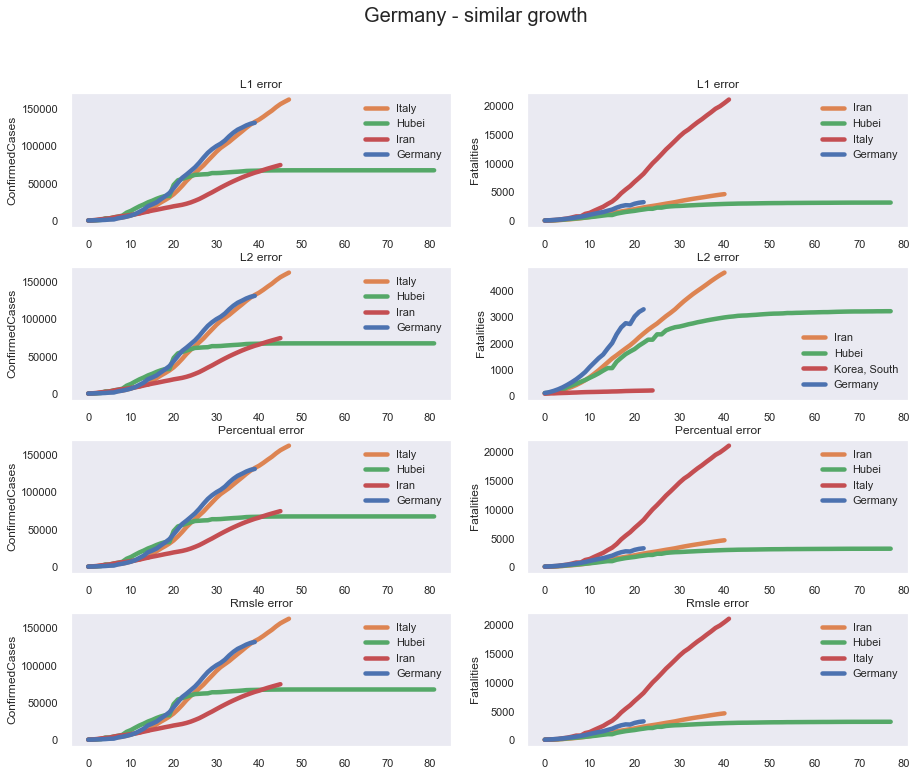

In [16]:
test_metrics(trainData, 'Germany', 500, 100)

#### 1.4.2 Specifc visualizations

In [17]:
def viz_country(trainData, sourceCountry, alignThreshConf, alignThreshDead):
    errorNames = ['RMSLE']
    error      = rmsle_error
    
    r = get_nearest_sequence(trainData, sourceCountry, alignThreshConf, alignThreshDead , error)
    show_country_nn(trainData, sourceCountry, alignThreshConf, alignThreshDead, [r], errorNames)

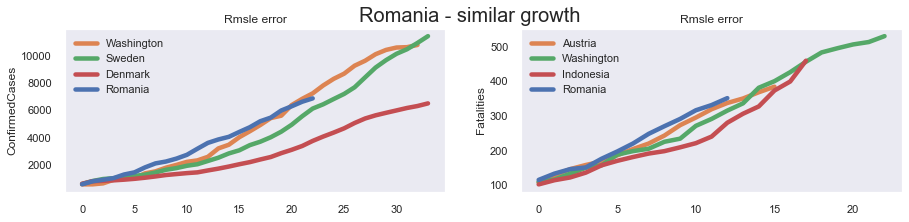

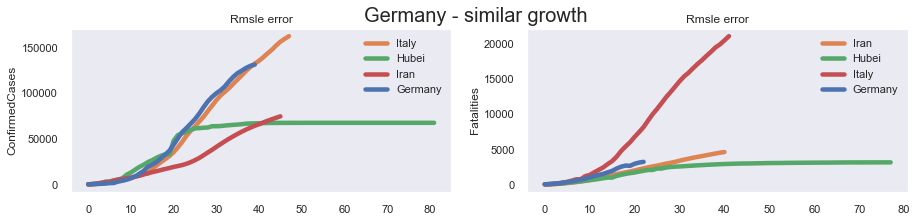

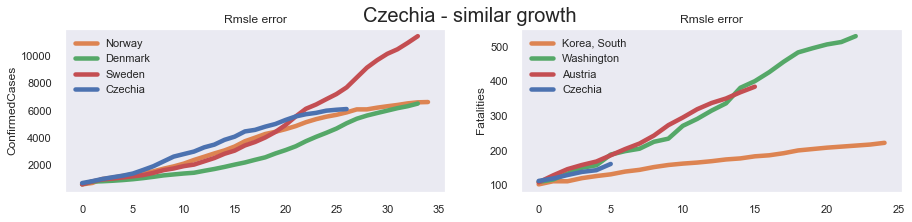

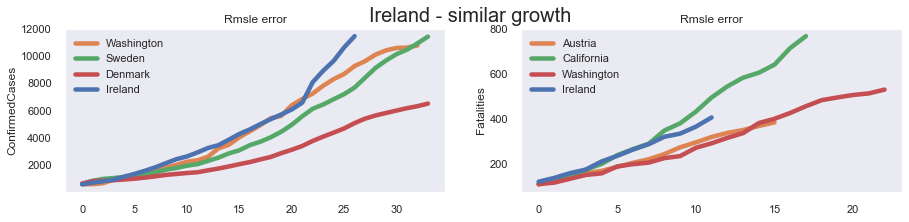

In [18]:
for country in ['Romania', 'Germany','Czechia', 'Ireland']:
    viz_country(trainData, country, 500, 100)

## 2. Adding more data

In [72]:
infoData = pd.read_csv('../assets/covid19countryinfo.csv')

In [73]:
def preprocess_info(df):
    df = df.rename(columns={'country':'Country_Region', 'region':'Province_State'})
    df = df.filter(['Province_State', 'Country_Region','pop', 'density',
                            'medianage', 'urbanpop', 'hospibed', 'smokers', 'sexratio', 'gdp2019',
                            'healthperpop', 'fertility','avgtemp', 'avghumidity'])
    
    df['pop']     = df['pop'].apply(lambda x: float(str(x).replace(',', '')))
    df['gdp2019'] = df['gdp2019'].apply(lambda x: float(str(x).replace(',', '')))
    
    # fill the state field with name of the country (if it is null)
    renameState     = df['Province_State'].fillna(0).values
    renameCountries = df['Country_Region'].values
    renameState[renameState == 0] = renameCountries[renameState == 0]
    df['Province_State'] = renameState

    return df

In [74]:
infoData = preprocess_info(infoData)
infoData.head()

,Province_State,Country_Region,pop,density,medianage,urbanpop,hospibed,smokers,sexratio,gdp2019,healthperpop,fertility,avgtemp,avghumidity
0,Afghanistan,Afghanistan,38928346.0,60.0,18.0,25.0,0.5,NaN,1.03,18734.0,4.726633,5.12,6.216667,56.933333
1,Albania,Albania,2877797.0,105.0,36.0,63.0,2.9,29.4,0.98,15418.0,268.955733,1.51,13.950000,69.900000
2,Algeria,Algeria,43851044.0,18.0,29.0,73.0,1.9,NaN,1.03,172781.0,23.511413,2.70,19.566667,61.716667
3,Andorra,Andorra,77265.0,164.0,45.0,88.0,2.5,32.5,1.06,91527.0,76994.758300,1.40,7.383333,75.233333
4,Antigua and Barbuda,Antigua and Barbuda,97929.0,223.0,34.0,26.0,3.8,NaN,0.90,1688.0,11283.685120,2.00,NaN,NaN


In [75]:
infoData.columns

Index(['Province_State', 'Country_Region', 'pop', 'density', 'medianage',
       'urbanpop', 'hospibed', 'smokers', 'sexratio', 'gdp2019',
       'healthperpop', 'fertility', 'avgtemp', 'avghumidity'],
      dtype='object')

In [76]:
profile = ProfileReport(infoData, title='Country general information', html={'style':{'full_width':True}}, progress_bar=False)
profile.to_widgets()

In [128]:
from sklearn.preprocessing import StandardScaler

nameCols = ['Province_State', 'Country_Region']
featCols = [c for c in infoData.columns if c not in nameCols]# Separating out the features

infoDataFeat = infoData.loc[:, featCols].fillna(0).values
infoDataName = infoData.loc[:, nameCols]

infoDataFeat = StandardScaler().fit_transform(infoDataFeat)

In [129]:
NO_COMPONENTS = 3
pca = PCA(n_components=NO_COMPONENTS)

infoDataFeat = pca.fit_transform(infoDataFeat)

infoDataFeat = pd.DataFrame(data = infoDataFeat
             , columns = [f'princ_{i}' for i in range(NO_COMPONENTS)])
infoDataPca  = pd.concat([infoDataName, infoDataFeat], axis = 1)

In [130]:
infoDataPca

,Province_State,Country_Region,princ_0,princ_1,princ_2
0,Afghanistan,Afghanistan,-0.126158,-1.017885,-0.934000
1,Albania,Albania,1.403699,-0.076885,-0.203320
2,Algeria,Algeria,0.855696,-0.508813,-0.585764
3,Andorra,Andorra,2.535485,4.206406,0.399390
4,Antigua and Barbuda,Antigua and Barbuda,-0.669037,1.119664,0.080133
...,...,...,...,...,...
244,Washington,US,-3.444598,0.231607,0.337341
245,Washington DC,US,-3.444598,0.231607,0.337341
246,West Virginia,US,-3.444598,0.231607,0.337341
247,Wisconsin,US,-3.444598,0.231607,0.337341


In [131]:
profile = ProfileReport(infoDataFeat, title='Country general information', html={'style':{'full_width':True}}, progress_bar=False)
profile.to_widgets()

In [132]:
from sklearn import cluster

In [141]:
dbscan = cluster.OPTICS(eps=0.4, min_samples=10)
dbscan = dbscan.fit(infoDataFeat)

In [142]:
dbscan.labels_ 

array([-1,  1,  0, -1, -1, -1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1,  1,
        2, -1, -1,  0,  1, -1, -1,  1, -1,  2, -1, -1, -1, -1, -1,  1, -1,
       -1,  0, -1, -1,  2, -1,  1, -1,  1,  1,  1, -1,  0, -1,  2,  0, -1,
        2, -1, -1,  1, -1, -1,  2, -1,  1, -1, -1,  3,  3,  3,  3, -1, -1,
        1, -1, -1,  1,  2, -1, -1,  0, -1,  1, -1, -1, -1,  2, -1, -1,  1,
       -1, -1, -1, -1, -1,  1,  1, -1,  0, -1,  1, -1,  1, -1, -1,  1, -1,
       -1, -1,  1,  1, -1,  2, -1,  1,  1,  3, -1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1,  1,  1,  0, -1,  0, -1,  2,  3,  1, -1,  2, -1,
       -1,  1,  1,  0, -1,  0,  0,  0, -1,  1,  1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1, -1, -1,  0, -1,
        0,  1,  1,  2,  1, -1, -1,  2, -1,  2, -1, -1, -1, -1,  1, -1, -1,
       -1, -1,  0, -1, -1, -1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3